In [1]:
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model
from keras.initializers import RandomNormal

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [3]:
# line_dataset is pre-shuffled
f = np.load('line_dataset.npz')
print(f.files)

['x', 'y_length', 'y_width', 'y_colour', 'y_angle']


In [4]:
train = int(.8 * f['x'].shape[0])
validate = int(.9 * f['x'].shape[0])
test = int(f['x'].shape[0])
print(train, validate-train, test-validate)

76800 9600 9600


In [5]:
# Splitting data
x_train = f['x'][:train]
x_validate = f['x'][train:validate]
x_test = f['x'][validate:test]

y_length_train = f['y_length'][:train].argmax(axis=1)
y_length_validate = f['y_length'][train:validate].argmax(axis=1)
y_length_test = f['y_length'][validate:test].argmax(axis=1)

y_width_train = f['y_width'][:train].argmax(axis=1)
y_width_validate = f['y_width'][train:validate].argmax(axis=1)
y_width_test = f['y_width'][validate:test].argmax(axis=1)

y_colour_train = f['y_colour'][:train].argmax(axis=1)
y_colour_validate = f['y_colour'][train:validate].argmax(axis=1)
y_colour_test = f['y_colour'][validate:test].argmax(axis=1)

y_angle_train = f['y_angle'][:train]
y_angle_validate = f['y_angle'][train:validate]
y_angle_test = f['y_angle'][validate:test]

# Model

In [6]:
input_image = Input(shape=(28,28,3), batch_shape=(None,28,28,3), dtype=float,name='Input_Image') 
conv = Conv2D(filters=8, kernel_size=7, padding='same', activation='relu')(input_image)
conv = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(conv) 
conv = Conv2D(filters=6, kernel_size=5, padding='valid', activation='relu')(conv)
conv = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='valid')(conv)
fmap = Flatten()(conv)

In [7]:
# Classification Head 1 - Length Classification
x = Dense(128, activation='relu')(fmap)
x = Dense(32, activation='relu')(x)
length = Dense(1, activation='sigmoid', name='length')(x)

In [8]:
# Classification Head 2 - Width Classification
x = Dense(64, activation='relu')(fmap)
width = Dense(1, activation='sigmoid', name='width')(x)

In [9]:
# Classification Head 3 - Colour Classification
x = Dense(64, activation='relu')(fmap)
colour = Dense(1, activation='sigmoid', name='colour')(x)

In [10]:
# Classification Head 4 - Angle Classification
x = Dense(256, activation='relu')(fmap)
x = Dense(64, activation='relu')(x)
angle = Dense(12, activation='softmax', name='angle')(x)

In [11]:
model = Model(inputs=input_image, 
              outputs=[length, width, colour, angle])
model.compile(optimizer='adam',
              loss={'length':'binary_crossentropy',
                    'width':'binary_crossentropy',
                    'colour':'binary_crossentropy',
                    'angle':'categorical_crossentropy'},
              metrics={'length':'accuracy',
                    'width':'accuracy',
                    'colour':'accuracy',
                    'angle':'accuracy'},
              )
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Image (InputLayer)        (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 8)    1184        Input_Image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 10, 6)    1206        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [12]:
history1 = model.fit(x=x_train,
                  y={'length':y_length_train,
                     'width':y_width_train,
                     'colour':y_colour_train,
                     'angle':y_angle_train},
                  batch_size=6400,
                  epochs=15,
                  verbose=1,
                  validation_data=(x_validate, 
                    {'length':y_length_validate,
                     'width':y_width_validate,
                     'colour':y_colour_validate,
                     'angle':y_angle_validate}),
                  shuffle=False # data is pre-shuffled, don't waste computation time
                 )

Train on 76800 samples, validate on 9600 samples
Epoch 1/15
76800/76800 [==============================] - 72s 933us/step - loss: 14.9079 - length_loss: 1.9733 - width_loss: 2.6963 - colour_loss: 2.4936 - angle_loss: 7.7447 - length_acc: 0.5875 - width_acc: 0.5617 - colour_acc: 0.6357 - angle_acc: 0.1728 - val_loss: 5.5593 - val_length_loss: 0.7712 - val_width_loss: 1.0950 - val_colour_loss: 0.7116 - val_angle_loss: 2.9816 - val_length_acc: 0.6261 - val_width_acc: 0.6228 - val_colour_acc: 0.7691 - val_angle_acc: 0.2175
Epoch 2/15
76800/76800 [==============================] - 72s 939us/step - loss: 4.2865 - length_loss: 0.6885 - width_loss: 0.7863 - colour_loss: 0.3917 - angle_loss: 2.4201 - length_acc: 0.6330 - width_acc: 0.6726 - colour_acc: 0.8490 - angle_acc: 0.2352 - val_loss: 3.4719 - val_length_loss: 0.6212 - val_width_loss: 0.5524 - val_colour_loss: 0.1612 - val_angle_loss: 2.1371 - val_length_acc: 0.6564 - val_width_acc: 0.7408 - val_colour_acc: 0.9364 - val_angle_acc: 0.2786


In [13]:
model.save('Q2-v2.h5')

In [14]:
metrics = model.evaluate(x=x_test,
                       y={'length':y_length_test,
                          'width':y_width_test,
                          'colour':y_colour_test,
                          'angle':y_angle_test},
                       verbose=1
                      )

9600/9600 [==============================] - 5s 526us/step


In [15]:
print(model.metrics_names, metrics)

['loss', 'length_loss', 'width_loss', 'colour_loss', 'angle_loss', 'length_acc', 'width_acc', 'colour_acc', 'angle_acc'] [0.26538193464279175, 0.03528714119534319, 0.00651800599969647, 0.001692943176779309, 0.22188384436070918, 0.9903125, 0.9986458333333333, 0.9995833333333334, 0.9221875]


In [16]:
print(history1.history.keys())

dict_keys(['val_loss', 'val_length_loss', 'val_width_loss', 'val_colour_loss', 'val_angle_loss', 'val_length_acc', 'val_width_acc', 'val_colour_acc', 'val_angle_acc', 'loss', 'length_loss', 'width_loss', 'colour_loss', 'angle_loss', 'length_acc', 'width_acc', 'colour_acc', 'angle_acc'])


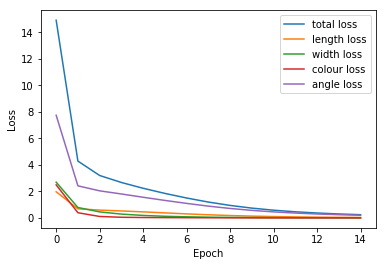

In [17]:
plt.plot(history1.history['loss'], label='total loss')
plt.plot(history1.history['length_loss'], label='length loss')
plt.plot(history1.history['width_loss'], label='width loss')
plt.plot(history1.history['colour_loss'], label='colour loss')
plt.plot(history1.history['angle_loss'], label='angle loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

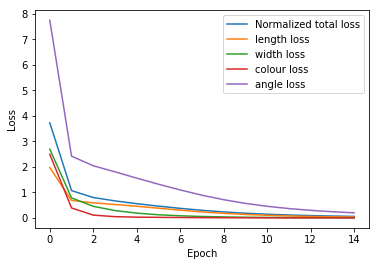

In [18]:
plt.plot(np.array(history1.history['loss'])/4, label='Normalized total loss')
plt.plot(history1.history['length_loss'], label='length loss')
plt.plot(history1.history['width_loss'], label='width loss')
plt.plot(history1.history['colour_loss'], label='colour loss')
plt.plot(history1.history['angle_loss'], label='angle loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

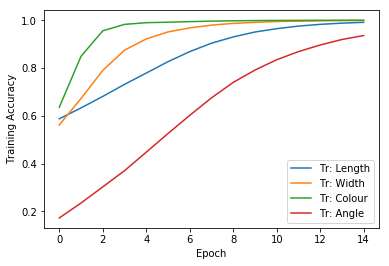

In [19]:
plt.plot(history1.history['length_acc'], label='Tr: Length')
plt.plot(history1.history['width_acc'], label='Tr: Width')
plt.plot(history1.history['colour_acc'], label='Tr: Colour')
plt.plot(history1.history['angle_acc'], label='Tr: Angle')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

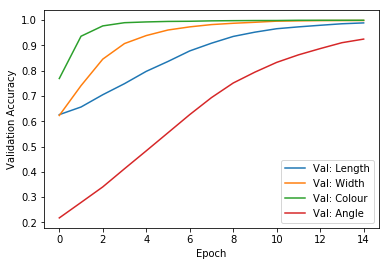

In [20]:
plt.plot(history1.history['val_length_acc'], label='Val: Length')
plt.plot(history1.history['val_width_acc'], label='Val: Width')
plt.plot(history1.history['val_colour_acc'], label='Val: Colour')
plt.plot(history1.history['val_angle_acc'], label='Val: Angle')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [21]:
length_p, width_p, colour_p, angle_p = model.predict(x=x_test, verbose=1)

9600/9600 [==============================] - 6s 574us/step


In [22]:
# Convert_to_class_labels
length_p = length_p.round().flatten()
width_p = width_p.round().flatten()
colour_p = colour_p.round().flatten()
angle_p = angle_p.argmax(axis=1)

In [23]:
# Get absolute class label
def get_absolute_class_label(l,w,c,a):
    return 42*l + 24*w + 12*c + a

In [24]:
y = get_absolute_class_label(y_length_test, y_width_test, y_colour_test, y_angle_test.argmax(axis=1))
y_hat = get_absolute_class_label(length_p, width_p, colour_p, angle_p)

In [25]:
print('Accuracies:')
acc_length = accuracy_score(y_length_test, length_p)
print('Length:', acc_length)
acc_width = accuracy_score(y_width_test, width_p)
print('Width:', acc_width)
acc_colour = accuracy_score(y_colour_test, colour_p)
print('Colour:', acc_colour)
acc_angle = accuracy_score(y_angle_test.argmax(axis=1), angle_p)
print('Angle:', acc_angle)
print('Average Accuracy:', np.average([acc_length, acc_width, acc_colour, acc_angle]))

Accuracies:
Length: 0.9903125
Width: 0.9986458333333333
Colour: 0.9995833333333334
Angle: 0.9221875
Average Accuracy: 0.9776822916666668


In [26]:
conmat = confusion_matrix(y, y_hat)

In [27]:
np.savez_compressed('v2_conmat.npz')

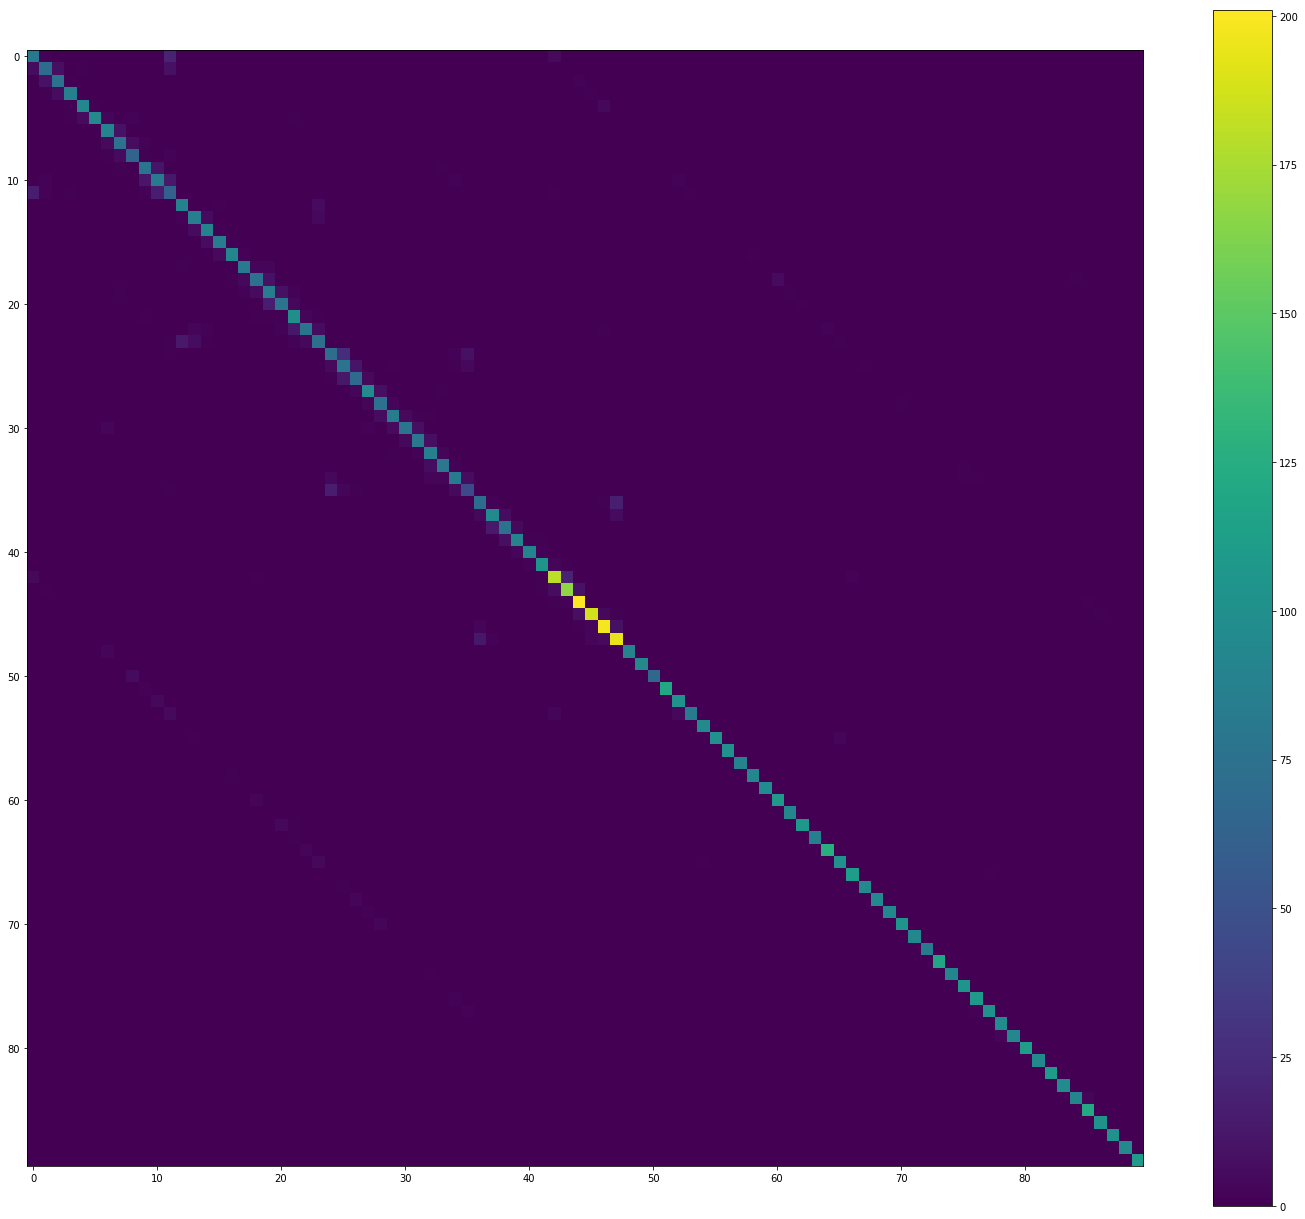

In [28]:
fig, ax = plt.subplots(1,1,figsize=(25,22))
im = ax.imshow(conmat)
plt.colorbar(im)
plt.show()

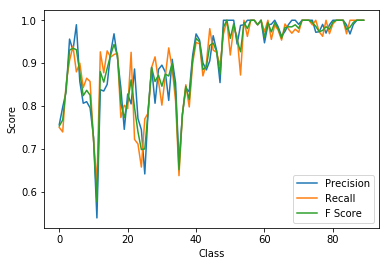

In [29]:
recall = recall_score(y, y_hat, average=None)
precision = precision_score(y, y_hat, average=None)
fscores = f1_score(y, y_hat, average=None)
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(fscores, label='F Score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()
plt.show()

In [30]:
print('------Length-----')
length_conmat = confusion_matrix(y_length_test, length_p)
print(length_conmat)
length_fscore = f1_score(y_length_test, length_p)
length_precision = precision_score(y_length_test, length_p)
length_recall = recall_score(y_length_test, length_p)
print('Precision:', length_precision)
print('Recall:', length_recall)
print('F score:', length_fscore)

------Length-----
[[4662   36]
 [  57 4845]]
Precision: 0.9926244622003688
Recall: 0.9883720930232558
F score: 0.99049371358479


In [31]:
print('------Width-----')
width_conmat = confusion_matrix(y_width_test, width_p)
print(width_conmat)
width_fscore = f1_score(y_width_test, width_p)
width_precision = precision_score(y_width_test, width_p)
width_recall = recall_score(y_width_test, width_p)
print('Precision:', width_precision)
print('Recall:', width_recall)
print('F score:', width_fscore)

------Width-----
[[4788    7]
 [   6 4799]]
Precision: 0.9985434873075323
Recall: 0.9987513007284079
F score: 0.9986473832067423


In [32]:
print('------Colour-----')
colour_conmat = confusion_matrix(y_colour_test, colour_p)
print(colour_conmat)
colour_fscore = f1_score(y_colour_test, colour_p)
colour_precision = precision_score(y_colour_test, colour_p)
colour_recall = recall_score(y_colour_test, colour_p)
print('Precision:', colour_precision)
print('Recall:', colour_recall)
print('F score:', colour_fscore)

------Colour-----
[[4730    1]
 [   3 4866]]
Precision: 0.9997945346209164
Recall: 0.9993838570548367
F score: 0.9995891536565324


------Angle-----
[[728  30   0   1   0   0   0   0   0   0   3  54]
 [ 22 716  32   0   1   1   0   0   0   0   1  26]
 [  1  44 726  12   0   0   0   0   0   0   0   0]
 [  0   1  25 754  10   1   0   0   0   1   0   0]
 [  0   0   0  12 779   8   0   0   0   0   0   0]
 [  1   0   0   1  15 765  14   5   3   1   0   0]
 [  0   0   0   2   1  11 715  50   0   0   0   0]
 [  0   0   0   0   0   3  22 746  34   4   0   0]
 [  0   0   0   0   0   1   2  26 711   9   0   2]
 [  0   0   0   0   0   0   1   2  17 752  20   2]
 [  7   5   2   0   0   0   0   0   6  33 782  37]
 [ 62  14   2   1   0   0   0   0   0   7  36 679]]


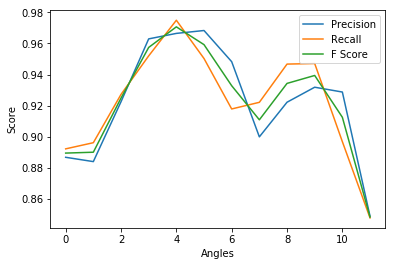

In [33]:
print('------Angle-----')
angle_conmat = confusion_matrix(y_angle_test.argmax(axis=1), angle_p)
print(angle_conmat)
angle_fscore = f1_score(y_angle_test.argmax(axis=1), angle_p, average=None)
angle_precision = precision_score(y_angle_test.argmax(axis=1), angle_p, average=None)
angle_recall = recall_score(y_angle_test.argmax(axis=1), angle_p, average=None)
plt.plot(angle_precision, label='Precision')
plt.plot(angle_recall, label='Recall')
plt.plot(angle_fscore, label='F Score')
plt.xlabel('Angles')
plt.ylabel('Score')
plt.legend()
plt.show()

In [34]:
np.savetxt('angle_conmat_v3.txt', angle_conmat, delimiter=' & ', fmt='%3d', newline='\\\\\n')